In [5]:
%%writefile mul.cu

#include <iostream>
#include <vector>
#include <cmath>
#include <cuda_runtime.h>
#include <chrono>
#include <fstream>
#include <omp.h>
#include <cblas.h>
#include <cublas_v2.h>

// Error checking macro
#define CUDA_CHECK(err)                                            \
    {                                                              \
        if (err != cudaSuccess)                                    \
        {                                                          \
            std::cerr << "CUDA error: " << cudaGetErrorString(err) \
                      << " in " << __FILE__                        \
                      << " at line " << __LINE__ << std::endl;     \
            std::exit(EXIT_FAILURE);                               \
        }                                                          \
    }

#define CUBLAS_CHECK(err)                                            \
    {                                                              \
        if (err != CUBLAS_STATUS_SUCCESS)                                    \
        {                                                          \
            std::cerr << "CUBLAS error: " << err \
                      << " in " << __FILE__                        \
                      << " at line " << __LINE__ << std::endl;     \
            std::exit(EXIT_FAILURE);                               \
        }                                                          \
    }


// CPU implementation of matrix multiplication (Column Major)
void mat_mul_cpu(const std::vector<float> &A,
                 const std::vector<float> &B,
                 std::vector<float> &C,
                 int N)
{
    for (int j = 0; j < N; ++j)
    {
        for (int i = 0; i < N; ++i)
        {
            float value = 0.0f;
            for (int k = 0; k < N; ++k)
            {
                value += A[k * N + i] * B[j * N + k];
            }
            C[j * N + i] = value;
        }
    }
}

// OpenMP CPU implementation of matrix multiplication (Column Major)
void mat_mul_openmp(const std::vector<float> &A,
                    const std::vector<float> &B,
                    std::vector<float> &C,
                    int N)
{
#pragma omp parallel for collapse(2)
    for (int j = 0; j < N; ++j)
    {
        for (int i = 0; i < N; ++i)
        {
            float value = 0.0f;
            for (int k = 0; k < N; ++k)
            {
                value += A[k * N + i] * B[j * N + k];
            }
            C[j * N + i] = value;
        }
    }
}

// OpenBLAS implementation of matrix multiplication (Column Major)
void mat_mul_openblas(const std::vector<float> &A,
                      const std::vector<float> &B,
                      std::vector<float> &C,
                      int N)
{
    cblas_sgemm(CblasColMajor, CblasNoTrans, CblasNoTrans,
                N, N, N, 1.0f, A.data(), N, B.data(), N, 0.0f, C.data(), N);
}


// GPU kernel for matrix multiplication (Column Major)
__global__ void mul_ma_kernel(const float *A, const float *B, float *C, int N)
{
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i < N && j < N)
    {
        float value = 0.0f;
        for (int k = 0; k < N; ++k)
        {
            value += A[k * N + i] * B[j * N + k];
        }
        C[j * N + i] = value;
    }
}

void mul_mat_gpu(const std::vector<float> &A,
                 const std::vector<float> &B,
                 std::vector<float> &C,
                 int N)
{
    float *d_A = nullptr, *d_B = nullptr, *d_C = nullptr;

    size_t bytes = N * N * sizeof(float);

    CUDA_CHECK(cudaMalloc(&d_A, bytes));
    CUDA_CHECK(cudaMalloc(&d_B, bytes));
    CUDA_CHECK(cudaMalloc(&d_C, bytes));

    CUDA_CHECK(cudaMemcpy(d_A, A.data(), bytes, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, B.data(), bytes, cudaMemcpyHostToDevice));

    dim3 block(32, 32);
    dim3 grid((N + block.x - 1) / block.x, (N + block.y - 1) / block.y);

    mul_ma_kernel<<<grid, block>>>(d_A, d_B, d_C, N);
    // CUDA_CHECK(cudaGetLastError());

    CUDA_CHECK(cudaMemcpy(C.data(), d_C, bytes, cudaMemcpyDeviceToHost));

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
}

// cuBLAS implementation of matrix multiplication (Column Major)
void mat_mul_cublas(const std::vector<float> &A,
                    const std::vector<float> &B,
                    std::vector<float> &C,
                    int N)
{
    cublasHandle_t handle;
    CUBLAS_CHECK(cublasCreate(&handle));

    float *d_A = nullptr, *d_B = nullptr, *d_C = nullptr;
    size_t bytes = N * N * sizeof(float);

    CUDA_CHECK(cudaMalloc(&d_A, bytes));
    CUDA_CHECK(cudaMalloc(&d_B, bytes));
    CUDA_CHECK(cudaMalloc(&d_C, bytes));

    CUDA_CHECK(cudaMemcpy(d_A, A.data(), bytes, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, B.data(), bytes, cudaMemcpyHostToDevice));

    const float alpha = 1.0f;
    const float beta = 0.0f;

    CUBLAS_CHECK(cublasSgemm(handle, CUBLAS_OP_N, CUBLAS_OP_N,
                             N, N, N, &alpha,
                             d_A, N,
                             d_B, N,
                             &beta,
                             d_C, N));

    CUDA_CHECK(cudaMemcpy(C.data(), d_C, bytes, cudaMemcpyDeviceToHost));

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    CUBLAS_CHECK(cublasDestroy(handle));
}


// Benchmark multiple sizes and export results to CSV
void benchmark_multiple_sizes(const std::vector<int> &sizes, int iterations)
{
    std::ofstream file("results.csv");
    file << "N,CPU_time_ms,OpenMP_time_ms,OpenBLAS_time_ms,GPU_time_ms,cuBLAS_time_ms,OpenMP_Speedup,OpenBLAS_Speedup,GPU_Speedup,cuBLAS_Speedup\n";

    for (int N : sizes)
    {
        std::vector<float> A(N * N), B(N * N), C_cpu(N * N), C_openmp(N * N), C_openblas(N * N), C_gpu(N * N), C_cublas(N * N);

        for (int i = 0; i < N * N; ++i)
        {
            A[i] = static_cast<float>(rand() % 100);
            B[i] = static_cast<float>(rand() % 100);
        }

        // Warm-up runs
        for (int i = 0; i < 2; ++i)
        {
            mat_mul_cpu(A, B, C_cpu, N);
            mat_mul_openmp(A, B, C_openmp, N);
            mat_mul_openblas(A, B, C_openblas, N);
            mul_mat_gpu(A, B, C_gpu, N);
            mat_mul_cublas(A, B, C_cublas, N);
        }

        auto start = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < iterations; ++i)
            mat_mul_cpu(A, B, C_cpu, N);
        auto end = std::chrono::high_resolution_clock::now();
        double cpu_ms = std::chrono::duration<double, std::milli>(end - start).count() / iterations;

        start = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < iterations; ++i)
            mat_mul_openmp(A, B, C_openmp, N);
        end = std::chrono::high_resolution_clock::now();
        double openmp_ms = std::chrono::duration<double, std::milli>(end - start).count() / iterations;

        start = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < iterations; ++i)
            mat_mul_openblas(A, B, C_openblas, N);
        end = std::chrono::high_resolution_clock::now();
        double openblas_ms = std::chrono::duration<double, std::milli>(end - start).count() / iterations;


        start = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < iterations; ++i)
            mul_mat_gpu(A, B, C_gpu, N);
        end = std::chrono::high_resolution_clock::now();
        double gpu_ms = std::chrono::duration<double, std::milli>(end - start).count() / iterations;

        start = std::chrono::high_resolution_clock::now();
        for (int i = 0; i < iterations; ++i)
            mat_mul_cublas(A, B, C_cublas, N);
        end = std::chrono::high_resolution_clock::now();
        double cublas_ms = std::chrono::duration<double, std::milli>(end - start).count() / iterations;


        double openmp_speedup = cpu_ms / openmp_ms;
        double openblas_speedup = cpu_ms / openblas_ms;
        double gpu_speedup = cpu_ms / gpu_ms;
        double cublas_speedup = cpu_ms / cublas_ms;


        std::cout << "N=" << N << " CPU=" << cpu_ms
                  << " ms OpenMP=" << openmp_ms
                  << " ms OpenBLAS=" << openblas_ms
                  << " ms GPU=" << gpu_ms
                  << " ms cuBLAS=" << cublas_ms
                  << " ms OpenMP_Speedup=" << openmp_speedup
                  << "x OpenBLAS_Speedup=" << openblas_speedup
                  << "x GPU_Speedup=" << gpu_speedup
                  << "x cuBLAS_Speedup=" << cublas_speedup << "x\n";


        file << N << "," << cpu_ms << "," << openmp_ms << "," << openblas_ms << "," << gpu_ms << "," << cublas_ms << "," << openmp_speedup << "," << openblas_speedup << "," << gpu_speedup << "," << cublas_speedup << "\n";
    }

    file.close();
    std::cout << "Benchmark results saved to results.csv ✅" << std::endl;
}

int main()
{
    std::vector<int> sizes = {256, 512, 768, 1024, 1500};
    int iterations = 5;

    benchmark_multiple_sizes(sizes, iterations);

    return 0;
}



Overwriting mul.cu


In [6]:
%%shell

nvcc mul.cu -o mul_cuda -Xcompiler -fopenmp -lblas -lcublas -lcusolver && ./mul_cuda

N=256 CPU=119.445 ms OpenMP=107.362 ms OpenBLAS=0.613062 ms GPU=0.492688 ms cuBLAS=1.91075 ms OpenMP_Speedup=1.11255x OpenBLAS_Speedup=194.834x GPU_Speedup=242.435x cuBLAS_Speedup=62.512x
N=512 CPU=1238.23 ms OpenMP=980.736 ms OpenBLAS=5.91531 ms GPU=1.41229 ms cuBLAS=1.78595 ms OpenMP_Speedup=1.26255x OpenBLAS_Speedup=209.325x GPU_Speedup=876.753x cuBLAS_Speedup=693.314x
N=768 CPU=3630.64 ms OpenMP=3327.12 ms OpenBLAS=21.7204 ms GPU=2.62103 ms cuBLAS=3.50697 ms OpenMP_Speedup=1.09123x OpenBLAS_Speedup=167.153x GPU_Speedup=1385.2x cuBLAS_Speedup=1035.27x
N=1024 CPU=13571.6 ms OpenMP=14613.3 ms OpenBLAS=28.0631 ms GPU=3.92614 ms cuBLAS=5.28078 ms OpenMP_Speedup=0.928719x OpenBLAS_Speedup=483.611x GPU_Speedup=3456.73x cuBLAS_Speedup=2570x
N=1500 CPU=37884.7 ms OpenMP=39078.5 ms OpenBLAS=83.4457 ms GPU=7.76447 ms cuBLAS=10.8342 ms OpenMP_Speedup=0.969452x OpenBLAS_Speedup=454.005x GPU_Speedup=4879.25x cuBLAS_Speedup=3496.77x
Benchmark results saved to results.csv ✅


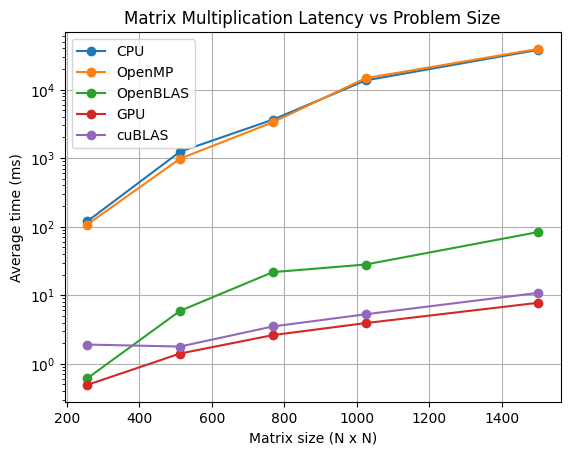

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

plt.figure()
plt.plot(df["N"], df["CPU_time_ms"], marker="o", label="CPU")
plt.plot(df["N"], df["OpenMP_time_ms"], marker="o", label="OpenMP")
plt.plot(df["N"], df["OpenBLAS_time_ms"], marker="o", label="OpenBLAS")
plt.plot(df["N"], df["GPU_time_ms"], marker="o", label="GPU")
plt.plot(df["N"], df["cuBLAS_time_ms"], marker="o", label="cuBLAS")
# make y logarithmic
plt.yscale("log")
plt.xlabel("Matrix size (N x N)")
plt.ylabel("Average time (ms)")
plt.title("Matrix Multiplication Latency vs Problem Size")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
%%writefile benchmark_openmp_threads.cpp
#include <iostream>
#include <vector>
#include <chrono>
#include <fstream>
#include <omp.h>

// Multiplication matricielle OpenMP (même logique que ton code principal)
void mat_mul_openmp(const std::vector<float> &A,
                    const std::vector<float> &B,
                    std::vector<float> &C,
                    int N)
{
#pragma omp parallel for collapse(2)
    for (int j = 0; j < N; ++j)
    {
        for (int i = 0; i < N; ++i)
        {
            float value = 0.0f;
            for (int k = 0; k < N; ++k)
            {
                value += A[k * N + i] * B[j * N + k];
            }
            C[j * N + i] = value;
        }
    }
}

int main()
{
    std::vector<int> sizes = {512, 768, 1024}; // tu peux ajuster
    std::vector<int> thread_counts = {1, 2, 4, 8, 16};
    int iterations = 3;

    std::ofstream file("results_threads.csv");
    file << "N,Threads,Time_ms\n";

    for (int N : sizes)
    {
        std::vector<float> A(N * N), B(N * N), C(N * N);
        for (int i = 0; i < N * N; ++i)
        {
            A[i] = static_cast<float>(rand() % 100);
            B[i] = static_cast<float>(rand() % 100);
        }

        for (int threads : thread_counts)
        {
            omp_set_num_threads(threads);

            auto start = std::chrono::high_resolution_clock::now();
            for (int it = 0; it < iterations; ++it)
                mat_mul_openmp(A, B, C, N);
            auto end = std::chrono::high_resolution_clock::now();

            double time_ms = std::chrono::duration<double, std::milli>(end - start).count() / iterations;

            std::cout << "N=" << N << " Threads=" << threads << " Time=" << time_ms << " ms\n";
            file << N << "," << threads << "," << time_ms << "\n";
        }
    }

    file.close();
    std::cout << "✅ Résultats enregistrés dans results_threads.csv\n";
    return 0;
}


Overwriting benchmark_openmp_threads.cpp


In [11]:
!g++ -fopenmp benchmark_openmp_threads.cpp -o benchmark_openmp_threads
!./benchmark_openmp_threads


N=512 Threads=1 Time=1490.22 ms
N=512 Threads=2 Time=1057.63 ms
N=512 Threads=4 Time=1084.2 ms
N=512 Threads=8 Time=1419.8 ms
N=512 Threads=16 Time=1099.7 ms
N=768 Threads=1 Time=4043.22 ms
N=768 Threads=2 Time=3546.74 ms
N=768 Threads=4 Time=3662.02 ms
N=768 Threads=8 Time=3593.48 ms
N=768 Threads=16 Time=3496.13 ms
N=1024 Threads=1 Time=14501.1 ms
N=1024 Threads=2 Time=15508.9 ms
N=1024 Threads=4 Time=15564.6 ms
N=1024 Threads=8 Time=15429 ms
N=1024 Threads=16 Time=15567.1 ms
✅ Résultats enregistrés dans results_threads.csv


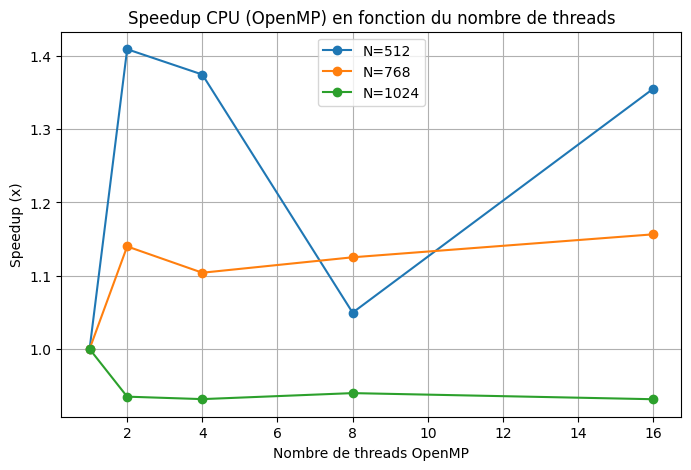

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les résultats
df = pd.read_csv("results_threads.csv")

# Calculer le speedup (temps 1 thread / temps N threads)
df["Speedup"] = df.groupby("N")["Time_ms"].transform(lambda x: x.iloc[0] / x)

plt.figure(figsize=(8,5))
for N in df["N"].unique():
    subset = df[df["N"] == N]
    plt.plot(subset["Threads"], subset["Speedup"], marker="o", label=f"N={N}")

plt.xlabel("Nombre de threads OpenMP")
plt.ylabel("Speedup (x)")
plt.title("Speedup CPU (OpenMP) en fonction du nombre de threads")
plt.grid(True)
plt.legend()
plt.show()
